In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# Brief Intro to TensorFlow
Key concepts in TensorFlow, which will be revisited and explained in the one-layer neural network below:
* Placeholder
* Variable
* Operation
* Graph
* Session

Nearly everything you see in TensorFlow falls into one or another categories.

Here is the diagram for the one-layer neural network.
<img src="simple_nn.png",width=400,height=400>

Read MNIST data with pandas.

In [2]:
train = pd.read_csv('../MNIST_data/train.csv', nrows=2000)

In [3]:
train.shape

(2000, 785)

MNIST train dataset has 42,000 samples. Each row consists of the digit to be predicted in the first column and flattened 28x28 greysale photo into 784 columns.

Shift pixels to between -1 and 1, zero centred.

In [4]:
pixels = (train.iloc[:, 1:] - 128) / 256

In [5]:
labels = train.iloc[:, 0]

Sneak peek of the first 5 digits.

In [6]:
labels.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

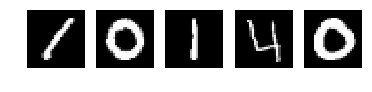

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=5)
for ax_id, ax in enumerate(axs):
    ax.imshow(train.iloc[ax_id, 1:].values.reshape((28, 28)), cm.gray)
    ax.set_axis_off()

In [8]:
label_onehot = np.zeros((pixels.shape[0], 10))
label_onehot[list(range(pixels.shape[0])), labels] = 1
label_onehot[:5]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now we come across *Placehoders*.

Key fact about it is it only passes on values to next TensorFlow elements instead of storing them.

In [9]:
input_pixels = tf.placeholder(tf.float32, shape=[None, 784], name='input_pixels')
train_labels = tf.placeholder(tf.int64, shape=[None], name='train_labels')

Next we meet *Variables* and *Operations*.

Long story short:
* Variables hold values that can be later updated and quiried upon.
* Operations alternate TensorFlow elements.

In [10]:
with tf.name_scope('hidden_layer'):
    w1 = tf.Variable(tf.random_normal([784, 50], mean=0, stddev=1), name='w1')
    b1 = tf.Variable(tf.zeros([50]), name='b1')
    layer1 = tf.sigmoid(tf.matmul(input_pixels, w1) + b1)
with tf.name_scope('output_layer'):
    w2 = tf.Variable(tf.random_normal([50, 10], mean=0, stddev=1), name='w2')
    b2= tf.Variable(tf.zeros([10]), name='b2')
    logits = tf.sigmoid(tf.matmul(layer1, w2) + b2, name='logits')

Variable w1 holds the weights between input pixels and the hidden layer.

Operation tf.random_normal defines how to initialise w1. Other operations include tf.matmul, tf.sigmoid. But what is tf.name_scope?

In [11]:
train_onehot_labels = tf.one_hot(
    indices=train_labels,
    depth=10,
    on_value=1,
    off_value=0,
)

In [12]:
with tf.name_scope('xent'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_onehot_labels, logits=logits))
    tf.summary.scalar('cross_entropies', cross_entropy)

Cross entropy minimisation is just another operation.

In [13]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy, name='train_step')

In [14]:
with tf.name_scope('accurary'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(train_onehot_labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracies', accuracy)

In [15]:
with tf.name_scope('prediction'):
    pred = tf.argmax(logits, 1, name='pred')

In [16]:
writer = tf.summary.FileWriter('/tmp/mnist/1')

In [17]:
init = tf.global_variables_initializer()

**ALL** defined elements above interconnect each other, which make a *Graph*. 

A graph depicts the data flow from input to output.

However, no real computation has ever occurred. A graph needs to be sent to computing sources cpu/gpu within a *Session* to do computation.

In [18]:
sess = tf.Session()

In [19]:
writer.add_graph(sess.graph)

In [20]:
batch_size = 100

Must initialise all variables before kicking off.

In [21]:
sess.run(init)

In [22]:
print(w1.eval(session=sess))

[[ 0.65627331 -1.45462024  0.6477527  ...,  1.15379238  0.26632708
   0.46562293]
 [-0.73828822 -0.25190377 -0.19740073 ...,  0.55967784  1.02986324
  -0.58706069]
 [ 1.07481205  0.66908216 -1.77047682 ..., -0.42017588  0.42465565
   1.44254375]
 ..., 
 [-0.28030655 -2.72346044  0.2181398  ...,  1.61596227  0.48724866
  -0.30890179]
 [ 0.15722509  1.12025201  0.57816344 ..., -0.76900393  1.21038198
   0.42087105]
 [-0.47549564 -0.33919019  0.04131202 ...,  0.5114727   0.41425341
   0.47400281]]


In [23]:
merged_summaries = tf.summary.merge_all()

When a session runs, input values are passed on through *feed_dict* to graph.

In [24]:
epochs = 3
batch_size = 100
batchs = 2000//100

In [25]:
for epoch in range(epochs):
    for batch in range(batchs):
        train_step.run(
            session=sess,
            feed_dict={
                input_pixels: pixels.iloc[batch*batch_size:(batch+1)*batch_size], 
                train_labels: labels.iloc[batch*batch_size:(batch+1)*batch_size]
            }
        )
        summaries = sess.run(
            merged_summaries,
            feed_dict={
                input_pixels: pixels.iloc[batch*batch_size:(batch+1)*batch_size], 
                train_labels: labels.iloc[batch*batch_size:(batch+1)*batch_size]
            }
        )
        writer.add_summary(summaries, epoch*batch_size+batch)

In [26]:
sess.run(accuracy, feed_dict={input_pixels: pixels, train_labels: labels})

0.101

In [27]:
sess.close()